In [ ]:
!pip install pydicom

     |████████████████████████████████| 1.9MB 7.0MB/s 


In [ ]:
import os
import sys
import time

from google.colab import drive

drive.mount('/content/drive')
IMAGES_DIR = '/content/drive/My Drive/Neural/dataset/stage_2_train_images'
LABELS_CSV_TMP = '/content/drive/My Drive/Neural/dataset/stage_2_train_labels.csv'
CLASS_INFO_CSV = '/content/drive/My Drive/Neural/dataset/stage_2_detailed_class_info.csv'
AUGMENTED_DATASET_FOLDER = '/content/drive/My Drive/Neural/augmented_dataset/'
AUGMENTED_IMAGES_FOLDER = '/content/drive/My Drive/Neural/augmented_dataset/training_images'
VALIDATION_IMAGES_FOLDER = '/content/drive/My Drive/Neural/augmented_dataset/validation_images'

print(IMAGES_DIR)
print(LABELS_CSV_TMP)
print(CLASS_INFO_CSV)
print(AUGMENTED_DATASET_FOLDER)
print(AUGMENTED_IMAGES_FOLDER)
print(VALIDATION_IMAGES_FOLDER )

Mounted at /content/drive
/content/drive/My Drive/Neural/dataset/stage_2_train_images
/content/drive/My Drive/Neural/dataset/stage_2_train_labels.csv
/content/drive/My Drive/Neural/dataset/stage_2_detailed_class_info.csv
/content/drive/My Drive/Neural/augmented_dataset/
/content/drive/My Drive/Neural/augmented_dataset/training_images
/content/drive/My Drive/Neural/augmented_dataset/validation_images


## Custom Dataset definition

Let's increase the data for each bouinding box with 'x_max' and 'y_max', in order to adopt the Pascal standard format

In [ ]:
import pandas as pd
import numpy as np

labels_csv = pd.read_csv(LABELS_CSV_TMP, )

# fill empty labels (class 0) with all 0
labels_csv.x.fillna(0, inplace=True)
labels_csv.y.fillna(0, inplace=True)
labels_csv.width.fillna(0, inplace=True)
labels_csv.height.fillna(0, inplace=True)

# add Pascal bounding boxes encoding
labels_csv['x_max'] = labels_csv['x']+labels_csv['width']
labels_csv['y_max'] = labels_csv['y']+labels_csv['height']

labels_csv.sample(10)

,patientId,x,y,width,height,Target,x_max,y_max
10693,7127c6c6-261a-4d76-bb98-fabb8595a6ea,0.0,0.0,0.0,0.0,0,0.0,0.0
19037,b1e41792-6891-46f6-916f-526d9942fcf1,0.0,0.0,0.0,0.0,0,0.0,0.0
19518,b50d8c2a-f6aa-407a-9df9-2a52cc027f45,197.0,326.0,231.0,614.0,1,428.0,940.0
26940,efc7bbac-8adb-4422-9249-282df5ccb6c9,0.0,0.0,0.0,0.0,0,0.0,0.0
2930,35071f53-b924-440e-bdfe-7e6f3c74989d,576.0,381.0,230.0,338.0,1,806.0,719.0
511,08378826-08b5-4853-a607-254a419fbac5,0.0,0.0,0.0,0.0,0,0.0,0.0
2757,33f0fb8e-35b4-4680-8f22-990a36899bfa,568.0,309.0,267.0,326.0,1,835.0,635.0
14239,8d48694a-f998-4043-bc98-63a3c18527f2,87.0,246.0,321.0,486.0,1,408.0,732.0
15356,961e98e3-f5d5-450d-9e98-04f83fcf47ea,0.0,0.0,0.0,0.0,0,0.0,0.0
14750,913802e2-820b-49e9-a48c-ec32949c1e8e,0.0,0.0,0.0,0.0,0,0.0,0.0


In [ ]:
from torch.utils.data import Dataset
import torch
import pydicom

def get_image_array(image_path):
  try:
    dcm_data = pydicom.read_file(image_path)
    img = dcm_data.pixel_array
    return img
  except:
      pass

def parse_one_annot(box_coord, filename):
  boxes_array = box_coord[box_coord["patientId"] == filename][["x", "y", "x_max", "y_max"]].values
  return boxes_array 

In [ ]:
class CXRimages(Dataset):
    def __init__(self, csv_file, images_dir, transform=None):
      self.path = images_dir
      self.annotations = csv_file
      self.transform = transform
      self.imgs = sorted(os.listdir(images_dir))


    def num_classes(self):
      return 3


    def __len__(self):
      return len(self.annotations)


    def __getitem__(self, idx):   #requires to define new indexes from 0
        patient_id = self.annotations['patientId'][idx]

        # load image
        img_path = os.path.join(self.path, patient_id +'.dcm')
        img = get_image_array(img_path) # only in case we are loading the dicom images directly

        # set bounding boxes
        box_list = parse_one_annot(self.annotations, patient_id)
        boxes = torch.as_tensor(box_list, dtype=torch.float32)
        num_objs = len(box_list)

        # set the box labels depending on patient label
        if len(torch.nonzero(boxes)) > 0:
          labels = torch.ones((num_objs,), dtype=torch.int64)
        else:
          labels = torch.zeros((num_objs,), dtype=torch.int64)

        # extra information for standard torchvision format (not really neeeded here)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:,0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # set metadata
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        target["patient_id"] = patient_id 

        if self.transform is not None:
                img = self.transform(img)

        return img, target

## Split Train + Validation dataset

Let's split dataset as: 
*   training => 90%
*   validation => 10%
  

In [ ]:
np.random.seed(13)
msk = np.random.rand(len(labels_csv)) < 0.9

# split and add indexes from 0 as required by class definition
train_df = labels_csv[msk].reset_index()  
val_df = labels_csv[~msk].reset_index()

print(f'Samples in train set: {len(train_df)} \nSamples in validation set: {len(val_df)} \n')

Samples in train set: 27239 
Samples in validation set: 2988 



In [ ]:
train_df[:10]

,index,patientId,x,y,width,height,Target,x_max,y_max
0,0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.0,0.0,0.0,0.0,0,0.0,0.0
1,1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0.0,0.0,0.0,0.0,0,0.0,0.0
2,2,00322d4d-1c29-4943-afc9-b6754be640eb,0.0,0.0,0.0,0.0,0,0.0,0.0
3,5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,818.0,605.0
4,6,00569f44-917d-4c86-a842-81832af98c30,0.0,0.0,0.0,0.0,0,0.0,0.0
5,7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,0.0,0.0,0.0,0.0,0,0.0,0.0
6,8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,483.0,681.0
7,9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,857.0,712.0
8,10,008c19e8-a820-403a-930a-bc74a4053664,0.0,0.0,0.0,0.0,0,0.0,0.0
9,11,009482dc-3db5-48d4-8580-5c89c4f01334,0.0,0.0,0.0,0.0,0,0.0,0.0


In [ ]:
val_df[:10]

,index,patientId,x,y,width,height,Target,x_max,y_max
0,3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0.0,0.0,0.0,0.0,0,0.0,0.0
1,4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,477.0,531.0
2,20,00f08de1-517e-4652-a04f-d1dc9ee48593,571.0,275.0,230.0,476.0,1,801.0,751.0
3,23,01027bc3-dc40-4165-a6c3-d6be2cb7ca34,0.0,0.0,0.0,0.0,0,0.0,0.0
4,35,019ca122-9cdf-4704-b7a9-449c8a1c263e,0.0,0.0,0.0,0.0,0,0.0,0.0
5,42,01a6eaa6-222f-4ea8-9874-bbd89dc1a1ce,609.0,285.0,236.0,355.0,1,845.0,640.0
6,56,01c7cc7c-7004-441f-9049-77b7b444dd6b,0.0,0.0,0.0,0.0,0,0.0,0.0
7,68,01e4fd43-4f2c-421f-bd68-c756dceb5742,0.0,0.0,0.0,0.0,0,0.0,0.0
8,72,01ef449e-d493-4db2-9162-d83c69f90f40,0.0,0.0,0.0,0.0,0,0.0,0.0
9,80,01fa0f5e-00c3-41cb-b5c7-10600c8633ae,602.0,438.0,101.0,101.0,1,703.0,539.0


## Test with no augmentation

In [ ]:
import torchvision.transforms as T

def To_tensor_tfms():
   transforms = []
   transforms.append(T.ToTensor())
   return T.Compose(transforms)

train_dataset = CXRimages(csv_file = train_df , images_dir = IMAGES_DIR, transform = To_tensor_tfms())
val_dataset = CXRimages(csv_file = val_df , images_dir = IMAGES_DIR, transform = To_tensor_tfms())
print(f'Samples in train set: {len(train_dataset)} \nSamples in validation set: {len(val_dataset)} \n')

Samples in train set: 27239 
Samples in validation set: 2988 



Let's show an example of custom dataset object

In [ ]:
train_dataset.__getitem__(3)

(tensor([[[0.0000, 0.0039, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
          [0.0000, 0.0039, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
          [0.0000, 0.0039, 0.0078,  ..., 0.0118, 0.0118, 0.0118],
          ...,
          [0.0039, 0.0118, 0.0157,  ..., 0.0275, 0.0275, 0.0275],
          [0.0000, 0.0078, 0.0118,  ..., 0.0196, 0.0196, 0.0196],
          [0.0000, 0.0000, 0.0039,  ..., 0.0000, 0.0000, 0.0000]]]),
 {'area': tensor([115968.]),
  'boxes': tensor([[562., 152., 818., 605.]]),
  'image_id': tensor([3]),
  'iscrowd': tensor([0]),
  'labels': tensor([1]),
  'patient_id': '00436515-870c-4b36-a041-de91049b9ab4'})

Let's plot some example images

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

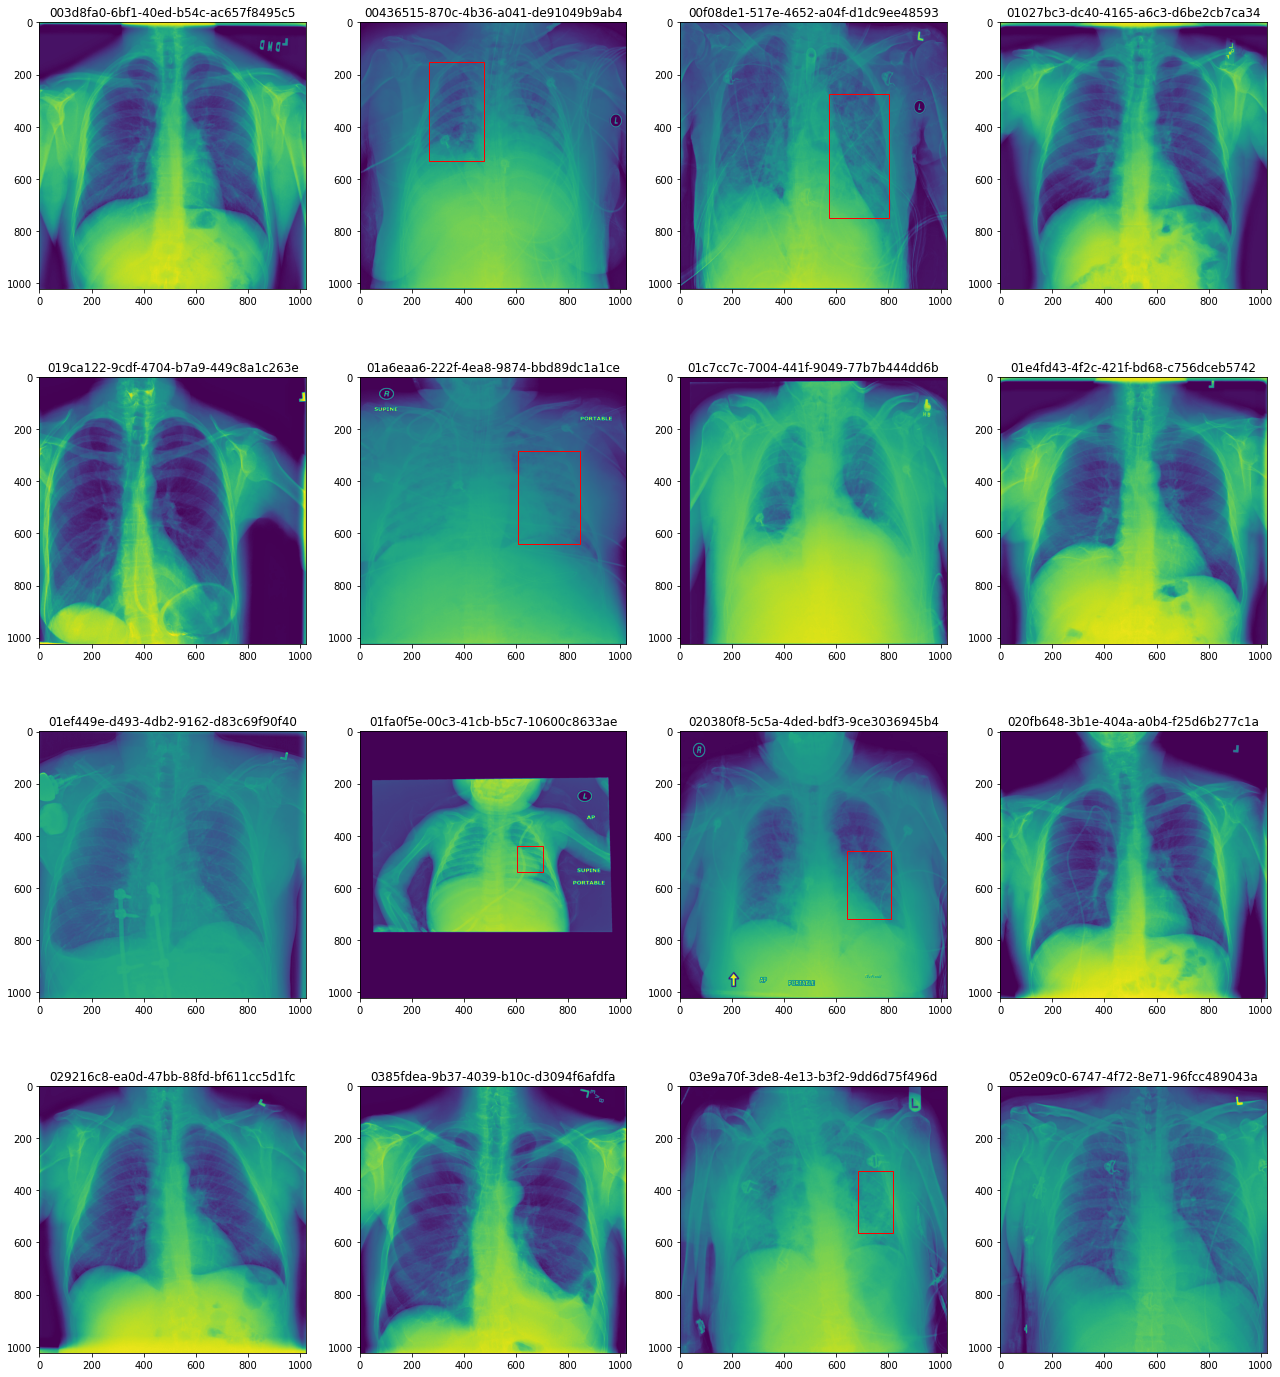

In [ ]:
def print_samples_with_boxes(dataset):

  # initalize variables for loop
  grid, gridx = plt.subplots(4,4, figsize=(22,25))
  old_patient_id = -1     # impossible value for a patient_id
  dataframe_counter = -1  # index refering to position in dataframe
  img_index = 0           # index refering to image position inside grid
  

  while img_index < 16:
    dataframe_counter += 1 

    # retrieve data
    data = val_dataset.__getitem__(dataframe_counter)
    patient_id = data[1]['patient_id']

    # check if it is new image, otherwise just skip
    if patient_id == old_patient_id:
      continue

    # other data needed
    image = data[0]
    boxes = data[1]['boxes']
    target = data[1]['labels'][0].item()

    # initialize image plot
    img = np.squeeze(image)
    gridx[img_index//4, img_index%4].set_title(patient_id)
    gridx[img_index//4, img_index%4].imshow(img)

    # bounding boxes (might be more for one pic)
    for j in range(len(boxes)):
      x1 = boxes[j][0]
      y1 = boxes[j][1]
      x2 = boxes[j][2]
      y2 = boxes[j][3]
      gridx[img_index//4, img_index%4].add_patch(patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none'))

    # this is needed to avoid showing duplicates in case of more bounding boxes
    old_patient_id = patient_id
    img_index += 1

  plt.show()


print_samples_with_boxes(train_dataset)

## Augmentation simple test

We do not want ToTensor transformaion here

In [ ]:
train_dataset_aug = CXRimages(csv_file = train_df , images_dir = IMAGES_DIR, transform = None)
val_dataset_aug = CXRimages(csv_file = val_df , images_dir = IMAGES_DIR, transform = None)
print(f'Samples in train set: {len(train_dataset)} \nSamples in validation set: {len(val_dataset)} \n')

Samples in train set: 27239 
Samples in validation set: 2988 



Let's first define a sequence with some standard augmentations

In [ ]:
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage


# list of some augmentations (just for the test)
seq = iaa.Sequential([
    iaa.Resize(512), # resize to 512x512
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.Flipud(0.2), # vertically flip 20% of all images
    iaa.Multiply((0.5, 1.5), per_channel=0.5), # Change brightness of images (50-150% of original value)
    iaa.LinearContrast((0.5, 2.0), per_channel=0.5), # Improve or worsen the contrast of images.
])

Let's apply the augmentations to a small sample of images

0 => original: BoundingBoxesOnImage([BoundingBox(x1=0.0000, y1=0.0000, x2=0.0000, y2=0.0000, label=None)], shape=(1024, 1024))
     augmented: BoundingBoxesOnImage([BoundingBox(x1=511.0000, y1=511.0000, x2=511.0000, y2=511.0000, label=None)], shape=(512, 512))
1 => original: BoundingBoxesOnImage([BoundingBox(x1=264.0000, y1=152.0000, x2=477.0000, y2=531.0000, label=None)], shape=(1024, 1024))
     augmented: BoundingBoxesOnImage([BoundingBox(x1=272.5000, y1=245.5000, x2=379.0000, y2=435.0000, label=None)], shape=(512, 512))
2 => original: BoundingBoxesOnImage([BoundingBox(x1=571.0000, y1=275.0000, x2=801.0000, y2=751.0000, label=None)], shape=(1024, 1024))
     augmented: BoundingBoxesOnImage([BoundingBox(x1=285.5000, y1=135.5000, x2=400.5000, y2=373.5000, label=None)], shape=(512, 512))
3 => original: BoundingBoxesOnImage([BoundingBox(x1=0.0000, y1=0.0000, x2=0.0000, y2=0.0000, label=None)], shape=(1024, 1024))
     augmented: BoundingBoxesOnImage([BoundingBox(x1=511.0000, y1=0.0000, 

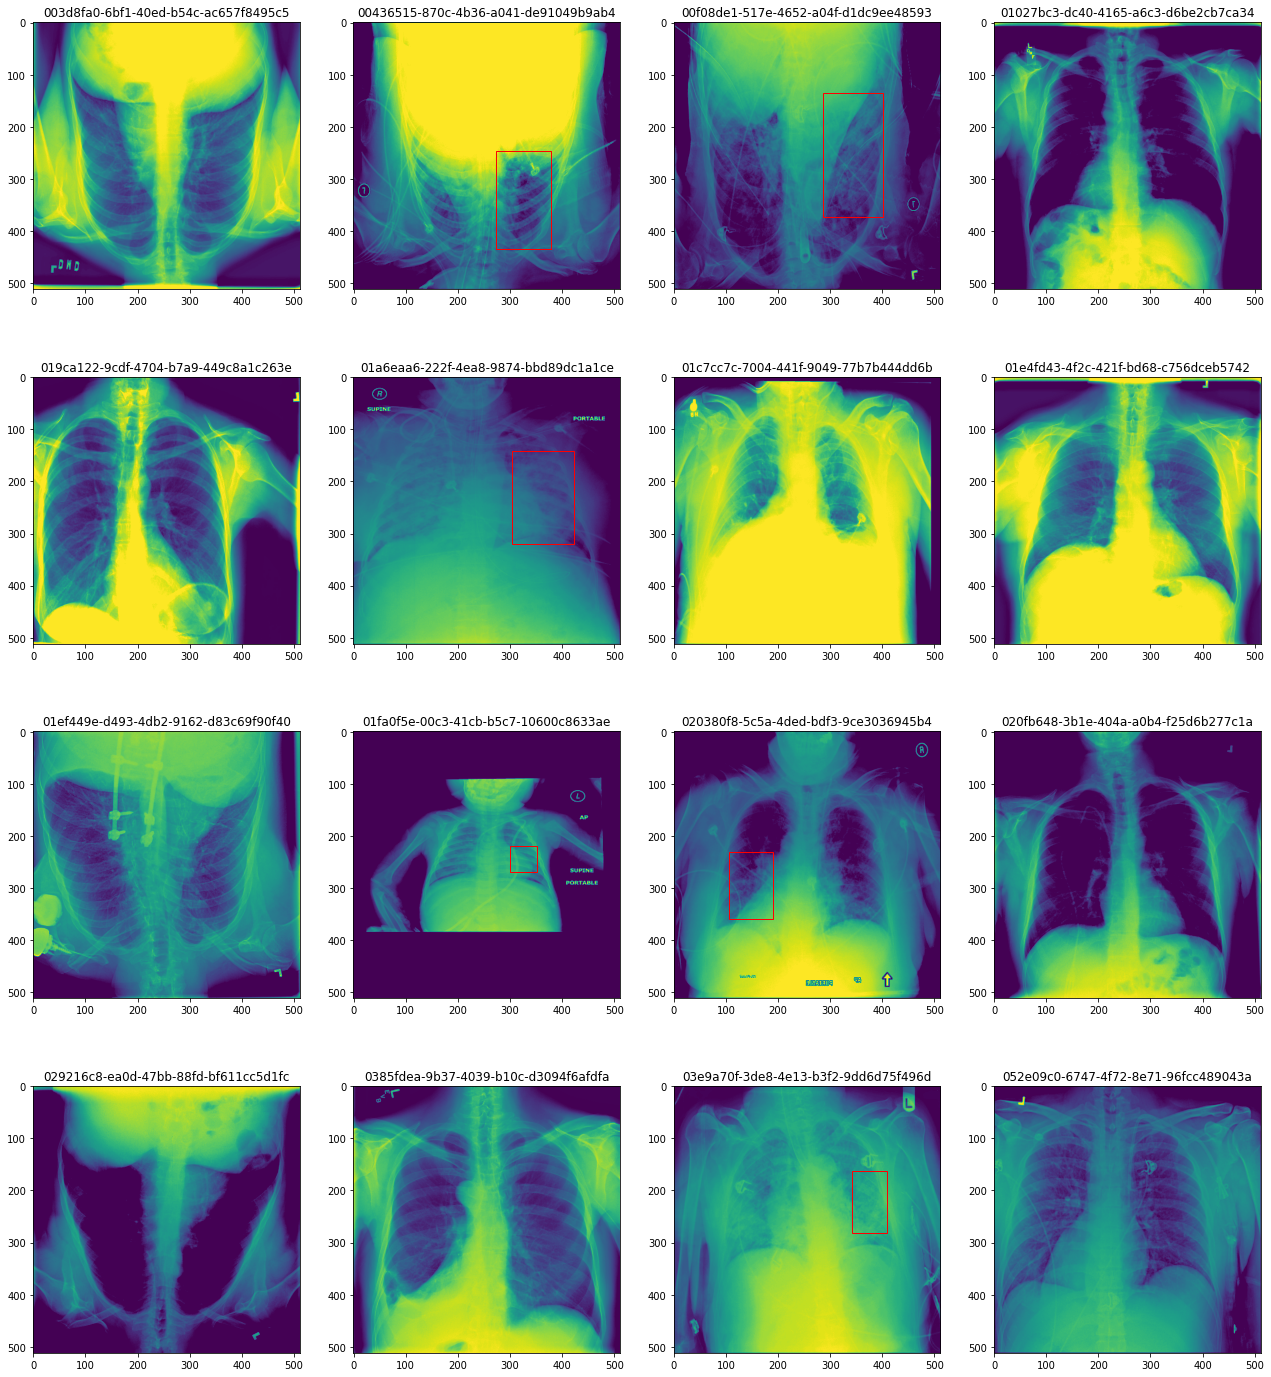

In [ ]:
def print_augmented_samples_with_boxes(dataset):
  # initalize variables for loop
  grid, gridx = plt.subplots(4,4, figsize=(22,25))
  old_patient_id = -1     # impossible value for a patient_id
  dataframe_counter = -1  # index refering to position in dataframe
  img_index = 0           # index refering to image position inside grid
  

  while img_index < 16:
    dataframe_counter += 1 

    # retrieve data
    data = val_dataset_aug.__getitem__(dataframe_counter)
    patient_id = data[1]['patient_id']

    # check if it is new image, otherwise just skip
    if patient_id == old_patient_id:
      continue

    # other data needed
    image = data[0]
    boxes = data[1]['boxes']
    target = data[1]['labels'][0].item()

    # bounding boxes encoding for imgaug sequential
    list_boxes = []
    for j in range(len(boxes)):
      list_boxes.append(BoundingBox(x1=boxes[j][0].item(), x2=boxes[j][2].item(), y1=boxes[j][1].item(), y2=boxes[j][3].item()))
    bbs = BoundingBoxesOnImage(list_boxes, shape=image.shape)

    # perform augmentation 
    image_aug, bbs_aug = seq(image=image, bounding_boxes=bbs)
    print(f'{img_index} => original:', bbs)
    print('     augmented:', bbs_aug)

    # start plot augmented sample
    gridx[img_index//4, img_index%4].set_title(patient_id)
    gridx[img_index//4, img_index%4].imshow(np.squeeze(image_aug))

    # extract augmented boxes (we do not care about Target0 cases)
    for box in bbs_aug.bounding_boxes:
      x1 = box.x1
      y1 = box.y1
      x2 = box.x2
      y2 = box.y2
      #print('augmented coordinates:', x1, y1, x2, y2)

      # add augmented bounding boxes to image 
      gridx[img_index//4, img_index%4].add_patch(patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none'))
    
    # this is needed to avoid showing duplicates in case of more bounding boxes
    old_patient_id = patient_id
    img_index += 1

  plt.show()

print_augmented_samples_with_boxes(train_dataset_aug)

## Training set augmentation

In [ ]:
from PIL import Image

Let's set the number of augmented copies and the type of augmentation. For the type select between:
- 'resize_only'
- 'light'
- 'heavy'
- 'heavy_with_rotations'

In [ ]:
augmentation_type = 'resize_only'

In [ ]:
def augmentation_level(level):
  if level == 'resize_only':
    list_augmentations = [
      iaa.Resize(512)            
    ]
    num_augmentations = 1

  elif level == 'light':
    list_augmentations = [
      iaa.Resize(512),
      iaa.Affine(
        scale=0.1, 
        shear=2.5, 
        rotate=(-5, 5), 
      ),    
    ]
    num_augmentations = 2
    
  elif level == 'heavy': #no rotation included
    list_augmentations = [
      iaa.Resize(512),
      iaa.Affine(
        scale=0.15, 
        shear=4.0,
      ),   
      iaa.Fliplr(0.2), # horizontally flip 20% of the images
      iaa.Sometimes(0.1, iaa.CoarseSaltAndPepper(p=(0.01, 0.01), size_percent=(0.1, 0.2))),
      iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0.0, 2.0))),
      iaa.Sometimes(0.5, iaa.AdditiveGaussianNoise(scale=(0, 0.04 * 255))),            
           
    ]
    num_augmentations = 3

  elif level == 'heavy_with_rotations':
    list_augmentations = [
      iaa.Resize(512),
      iaa.Affine(
        scale=0.15, 
        shear=4.0,
        rotate=(-6, 6), 
      ),   
      iaa.Fliplr(0.2), # horizontally flip 20% of the images
      iaa.Sometimes(0.1, iaa.CoarseSaltAndPepper(p=(0.01, 0.01), size_percent=(0.1, 0.2))),
      iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0.0, 2.0))),
      iaa.Sometimes(0.5, iaa.AdditiveGaussianNoise(scale=(0, 0.04 * 255))),            
    ]
    num_augmentations = 3

  return list_augmentations, num_augmentations


list_augmentations, num_augmentations = augmentation_level(augmentation_type)
seq_training = iaa.Sequential(list_augmentations)

Perform full training set augmentation and save 

In [ ]:
print(f'Augmentation ({augmentation_type}) training set.... ', end='')
start = time.time()

# initialize output dataframe
output_dataframe = pd.DataFrame(columns=['index', 'patientId',	'x', 'y', 'x_max', 'y_max', 'Target'])

# initalize variables for loop
old_patient_id = -1     # impossible value for a patient_id
output_index = -1       # counter for the output dataframe
dataframe_counter = 0   # counter for the input dataframe
dataset_images = len(train_dataset_aug)

while dataframe_counter < dataset_images:
  # retrieve data
  data = train_dataset_aug.__getitem__(dataframe_counter)
  patient_id = data[1]['patient_id']

  # check if it is new image, otherwise just skip
  if patient_id == old_patient_id:
    dataframe_counter += 1 
    continue

  # other data needed
  image = data[0]
  boxes = data[1]['boxes']
  target = data[1]['labels'][0].item()
  
  # bounding boxes encoding for imgaug sequential
  list_boxes = []
  for j in range(len(boxes)):
    list_boxes.append(BoundingBox(x1=boxes[j][0].item(), x2=boxes[j][2].item(), y1=boxes[j][1].item(), y2=boxes[j][3].item()))
  bbs = BoundingBoxesOnImage(list_boxes, shape=image.shape)

  # make a new augmented copy for each value in num_augmentations
  for aug_num in range(num_augmentations):
    # perform augmentation 
    image_aug, bbs_aug = seq_training(image=image, bounding_boxes=bbs)

    # save augmented image
    augmented_name = patient_id + '_' + str(aug_num)
    img = Image.fromarray(image_aug)
    image_path = os.path.join(AUGMENTED_IMAGES_FOLDER, augmented_name)
    img.save(image_path, 'png') 

    # iterate through boxes only if target==1, otherwise just write 0 everywhere
    if target == 1:
      # extract augmented boxes
      for box in bbs_aug.bounding_boxes:
        output_index += 1
        x1 = box.x1
        y1 = box.y1
        x2 = box.x2
        y2 = box.y2   

        # save new row in dataframe
        output_dataframe = output_dataframe.append({'index': output_index, 'patientId': augmented_name,	
                                                    'x': x1, 'y':y1, 'x_max':x2, 'y_max': y2, 'Target': target},
                                                    ignore_index=True)
    else:
      output_index += 1
      # save new row in dataframe
      output_dataframe = output_dataframe.append({'index': output_index, 'patientId': augmented_name,	
                                                    'x': 0, 'y':0, 'x_max':0, 'y_max': 0, 'Target': target},
                                                    ignore_index=True)

  # this is needed to avoid image duplicates in case of more bounding boxes
  old_patient_id = patient_id 
  dataframe_counter += 1 

# save dataframe as CSV 
output_dataframe.to_csv(path_or_buf=AUGMENTED_DATASET_FOLDER +'training_labels.csv', index=False)

end = time.time()
minutes = format((end - start)/60, '.2f')
print('done!')
print(f'Time required: {minutes} minutes')
print(f'validation_labels rows: {len(output_dataframe)}')

Augmentation (resize_only) training set.... done!
Time required: 182.87 minutes
validation_labels rows: 27239


## Apply resize to Validation set

Perform full validation set resize

In [ ]:
seq_validation = iaa.Sequential([
    iaa.Resize(512)
])

In [ ]:
print('Resizing validation set.... ', end='')
start = time.time()

# initialize output dataframe
output_dataframe = pd.DataFrame(columns=['index', 'patientId',	'x', 'y', 'x_max', 'y_max', 'Target'])

# initalize variables for loop
old_patient_id = -1     # impossible value for a patient_id
output_index = -1       # counter for the output dataframe
dataframe_counter = 0   # counter for the input dataframe
dataset_images = len(val_dataset_aug)

while dataframe_counter < dataset_images:
  # retrieve data
  data = val_dataset_aug.__getitem__(dataframe_counter)
  patient_id = data[1]['patient_id']

  # check if it is new image, otherwise just skip
  if patient_id == old_patient_id:
    dataframe_counter += 1 
    continue

  # other data needed
  image = data[0]
  boxes = data[1]['boxes']
  target = data[1]['labels'][0].item()
  
  # bounding boxes encoding for imgaug sequential
  list_boxes = []
  for j in range(len(boxes)):
    list_boxes.append(BoundingBox(x1=boxes[j][0].item(), x2=boxes[j][2].item(), y1=boxes[j][1].item(), y2=boxes[j][3].item()))
  bbs = BoundingBoxesOnImage(list_boxes, shape=image.shape)

  # augmentation (just resize here)
  image_aug, bbs_aug = seq_validation(image=image, bounding_boxes=bbs)

  # save augmented image -------------
  img = Image.fromarray(image_aug)
  image_path = os.path.join(VALIDATION_IMAGES_FOLDER, patient_id)
  img.save(image_path, 'png') 

  # iterate through boxes only if target==1, otherwise just write 0
  if target == 1:
    # extract augmented boxes
    for box in bbs_aug.bounding_boxes:
      output_index += 1
      x1 = box.x1
      y1 = box.y1
      x2 = box.x2
      y2 = box.y2   

      # save new row in dataframe
      output_dataframe = output_dataframe.append({'index': output_index, 'patientId': patient_id,	
                                                  'x': x1, 'y':y1, 'x_max':x2, 'y_max': y2, 'Target': target},
                                                  ignore_index=True)
  else:
    output_index += 1
    # save new row in dataframe
    output_dataframe = output_dataframe.append({'index': output_index, 'patientId': patient_id,	
                                                  'x': 0, 'y':0, 'x_max':0, 'y_max': 0, 'Target': target},
                                                  ignore_index=True)

  # this is needed to avoid image duplicates in case of more bounding boxes
  old_patient_id = patient_id 
  dataframe_counter += 1 

# save dataframe as CSV 
output_dataframe.to_csv(path_or_buf=AUGMENTED_DATASET_FOLDER +'validation_labels.csv', index=False)

end = time.time()
minutes = format((end - start)/60, '.2f')
print('done!')
print(f'Time required: {minutes} minutes')
print(f'validation_labels rows: {len(output_dataframe)}')

Resizing validation set.... done!
Time required: 22.10 minutes
validation_labels rows: 2988
